In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import regularizers
from keras.models import load_model
from scipy.io.arff import loadarff 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px

os.environ["OMP_NUM_THREADS"] = '1'


print(
"TensorFlow version:", tf.__version__)
print("Num GPUs Available", len(tf.config.list_physical_devices('GPU')))


TensorFlow version: 2.17.0
Num GPUs Available 0


In [3]:
raw_data = loadarff('dataset.arff')
df = pd.DataFrame(raw_data[0])
df.head(10)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
5,5.586408,13.261073,0.064768,1.0,0.0,0.0,0.0,0.0
6,3.724019,0.956838,0.278465,1.0,0.0,0.0,1.0,0.0
7,4.848247,0.320735,1.273050,1.0,0.0,1.0,0.0,0.0
8,0.876632,2.503609,1.516999,0.0,0.0,0.0,0.0,0.0
9,8.839047,2.970512,2.361683,1.0,0.0,0.0,1.0,0.0


---
---
---

In [4]:
X = df.drop(columns=['fraud'])
y = df['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(10, activation='relu', input_shape=(X_train.shape[1],)))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

best_model = model.fit(X_train, y_train, epochs=100, batch_size=10)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
13063/80000 ━━━━━━━━━━━━━━━━━━━━ 30s 454us/step - accuracy: 0.9577 - loss: 0.1221

KeyboardInterrupt: 

In [33]:
model.save('model_big.h5')

In [57]:
history = best_model.history
loss = history['loss']
print(loss)

In [26]:
history_df = pd.DataFrame(best_model.history)
history_df.to_csv('training_history.csv', index=False)

In [80]:
# Load the training history
history_df = pd.read_csv('training_history.csv')

# Access loss and accuracy values
loss_values = history_df['loss']
accuracy_values = history_df['accuracy']

print('Loss:\n',loss_values)
print('Accuracy:\n', accuracy_values)

In [81]:
# Load the model from the .h5 file
loaded_model = load_model('model_big.h5')

# Evaluate the model on test data to get loss and accuracy
loss, accuracy = loaded_model.evaluate(X_test, y_test)

# Print the loss
print(f"Loss: {loss}")

In [82]:
y_pred = loaded_model.predict(X_test)
y_pred_classes = tf.argmax(y_pred, axis=1)

print("classification_report: \n", classification_report(y_test, y_pred_classes))

In [83]:
history = loaded_model.fit(X_train,y_train,epochs = 50, batch_size = 10, validation_data =(X_test, y_test))

In [84]:
plt.figure(figsize = (12,4))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

---
---
---

In [49]:
def build_model(n_neurons_layer1, n_neurons_layer2, dropout_rate, activation, optimizer, learning_rate):
  model = tf.keras.models.Sequential()
  
  model.add(tf.keras.layers.Dense(n_neurons_layer1, activation=activation, input_shape=(X_train.shape[1],)))
  model.add(tf.keras.layers.Dropout(dropout_rate))
  
  model.add(tf.keras.layers.Dense(n_neurons_layer2, activation=activation))
  model.add(tf.keras.layers.Dropout(dropout_rate))

  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  if optimizer == 'adam':
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  elif optimizer == 'sgd':
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)


  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [56]:
# Is litterly killing my computer send help.
# 
# Its taking more than 8GB Vram send me money so I can buy a a100 (600K kr)


model = KerasClassifier(model=build_model, verbose=0)

param_grid = {
    "model__n_neurons_layer1" : [10],
    "model__n_neurons_layer2" : [8],
    "model__dropout_rate" : [0.2],
    "model__activation" : ["relu"],
    "model__optimizer" : ["adam"],
    'model__learning_rate': [0.01],
    'epochs': [100],
    'batch_size': [10]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=4, cv=3, verbose=1)
grid_result = grid.fit(X_train, y_train)

In [ ]:
print("Best Parameters: ", grid_result.best_params_)
print("Best Result (accuracy): ", grid_result.best_score_)

best_model = grid_result.best_estimator_
best_params = grid_result.best_params_
best_model.save('best_model.h5')
best_params.save('best_params.h5')

---
---
---

In [6]:
X = df.drop(columns=['fraud'])
y = df['fraud']

X_sampled, _, y_sampled, _ = train_test_split(X, y, train_size=250000, stratify=y, random_state=42)

# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_sampled, y_sampled)

undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_sampled, y_sampled)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
dropout_rate = 0.3

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(500, activation='relu', input_shape=(X_train.shape[1],)))
model.add(tf.keras.layers.Dropout(dropout_rate))
model.add(tf.keras.layers.Dense(250, activation='relu'))
model.add(tf.keras.layers.Dropout(dropout_rate))
model.add(tf.keras.layers.Dense(125, activation='relu'))
model.add(tf.keras.layers.Dropout(dropout_rate))

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

model.fit(X_resampled, y_resampled, epochs=50, batch_size=10, class_weight=class_weights_dict)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
4371/4371 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7615 - loss: 0.8444
Epoch 2/50
4371/4371 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9117 - loss: 0.2069
Epoch 3/50
4371/4371 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9232 - loss: 0.1901
Epoch 4/50
4371/4371 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9269 - loss: 0.1833
Epoch 5/50
4371/4371 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9263 - loss: 0.1872
Epoch 6/50
4371/4371 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9317 - loss: 0.1603
Epoch 7/50
4371/4371 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9323 - loss: 0.1692
Epoch 8/50
4371/4371 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9398 - loss: 0.1592
Epoch 9/50
4371/4371 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9445 - loss: 0.1294
Epoch 10/50
4371/4371 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9485 - loss: 0.1167
Epoch 11/50
4371/4371 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9437 - loss: 0.1473
Epoch 12/50
4371/4371 ━━━━━━━━

KeyboardInterrupt: 

In [42]:
model.save('model_testing.h5')

In [8]:
# Load the model
loaded_model = load_model('model_smote.h5')

# Make predictions (outputs probabilities between 0 and 1)
y_pred_probs = loaded_model.predict(X_test)

# Convert probabilities to binary class predictions (0 or 1)
y_pred_classes = (y_pred_probs >= 0.3).astype(int).reshape(-1)

# Print the classification report
print("classification_report: \n", classification_report(y_test, y_pred_classes))
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print(conf_matrix)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 574us/step
classification_report: 
               precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    182557
         1.0       1.00      0.23      0.37     17443

    accuracy                           0.93    200000
   macro avg       0.97      0.62      0.67    200000
weighted avg       0.94      0.93      0.91    200000

[[182551      6]
 [ 13420   4023]]


Classification Report at threshold 0.1:
               precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    182557
         1.0       1.00      0.23      0.38     17443

    accuracy                           0.93    200000
   macro avg       0.96      0.62      0.67    200000
weighted avg       0.94      0.93      0.91    200000



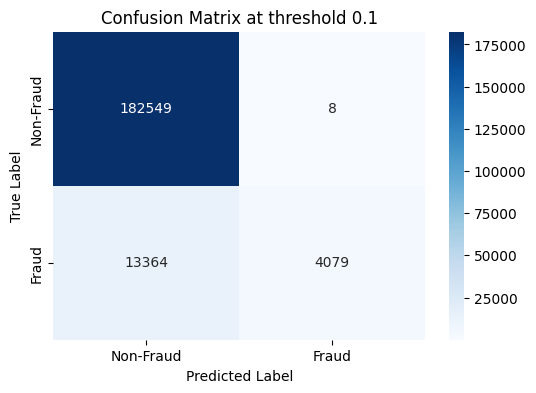

Classification Report at threshold 0.3:
               precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    182557
         1.0       1.00      0.23      0.37     17443

    accuracy                           0.93    200000
   macro avg       0.97      0.62      0.67    200000
weighted avg       0.94      0.93      0.91    200000



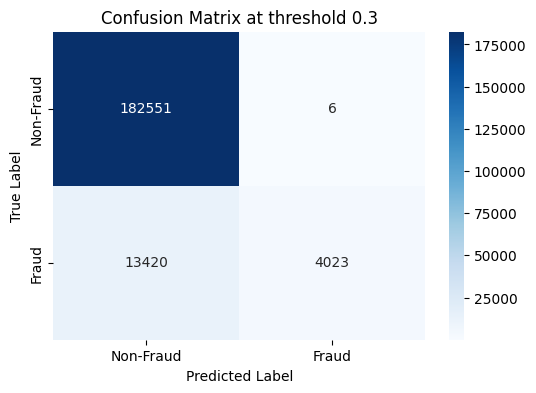

Classification Report at threshold 0.5:
               precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    182557
         1.0       1.00      0.23      0.37     17443

    accuracy                           0.93    200000
   macro avg       0.96      0.61      0.67    200000
weighted avg       0.94      0.93      0.91    200000



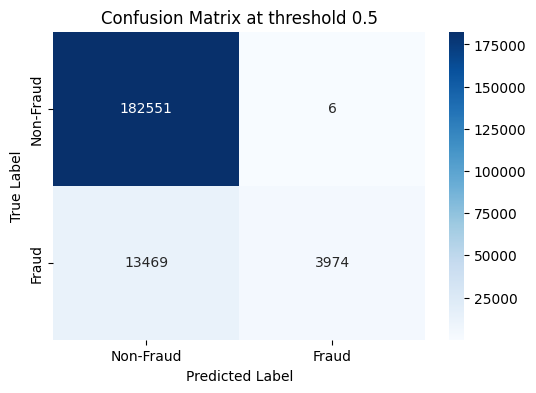

Classification Report at threshold 0.7:
               precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    182557
         1.0       1.00      0.23      0.37     17443

    accuracy                           0.93    200000
   macro avg       0.96      0.61      0.67    200000
weighted avg       0.94      0.93      0.91    200000



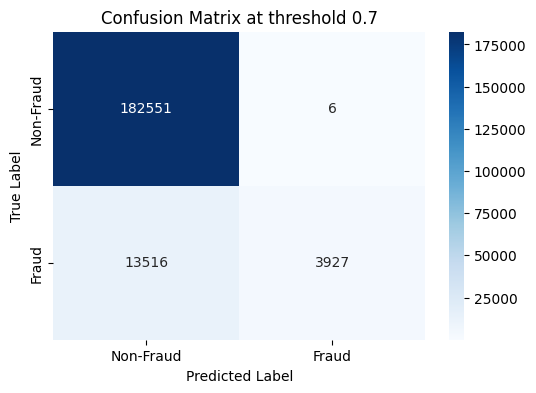

Classification Report at threshold 0.9:
               precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    182557
         1.0       1.00      0.22      0.36     17443

    accuracy                           0.93    200000
   macro avg       0.96      0.61      0.66    200000
weighted avg       0.94      0.93      0.91    200000



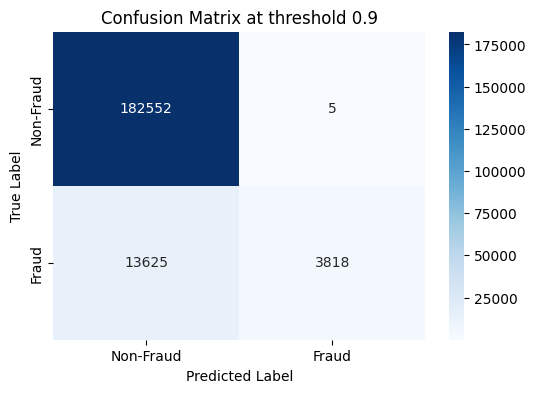

In [9]:
def evaluate_at_threshold(threshold):
    # Convert probabilities to binary class predictions using the given threshold
    y_pred_classes = (y_pred_probs >= threshold).astype(int).reshape(-1)

    # Print the classification report
    print(f"Classification Report at threshold {threshold}:\n", classification_report(y_test, y_pred_classes))

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'Confusion Matrix at threshold {threshold}')
    plt.show()

    return conf_matrix

# Test different thresholds: 0.1, 0.3, 0.5, 0.7, 0.9
for threshold in [0.1, 0.3, 0.5, 0.7, 0.9]:
    evaluate_at_threshold(threshold)